In this notebook, I am going to write an object detection, which detects cars in images. I am going to write it by OpenCV with YOLOv4 trained model that I have already trained with Darknet framework, the model training notebook is also included in this repository under the name "YOLOv4_training".

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

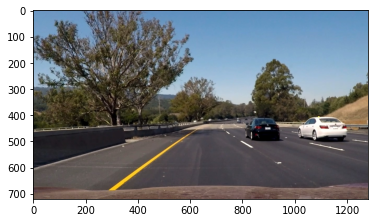

In [23]:
# Reading the image by opencv
image_path = '/content/gdrive/MyDrive/YOLO/test_images/test6.jpg'
image = cv2.imread(image_path)
# Here we need to convert the image to RGB because OpenCV reads the images with BGR sequence channel. 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Plot the image by matplotlib library
plt.imshow(image)

In [24]:
# Get the height and the width of the image 
print("Image shape: {}".format(image.shape))
height, width = image.shape[:2]
print("Image height: {}".format(height))
print("Image width: {}".format(width))

Image shape: (720, 1280, 3)
Image height: 720
Image width: 1280


In [5]:
print(cv2.__version__)

3.4.13


In [6]:
# # Install an OpenCV version that support YOLOv4
!pip install opencv-contrib-python==3.4.13.47 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53.7 MB 171 kB/s 
     |████████████████████████████████| 15.7 MB 31.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [25]:
# Blob the image to feed it into the network
# blobFromImage function returns 4-dimensional blob (#images, #channels, height, width)
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
print("Image shape: {}".format(blob.shape))

Image shape: (1, 3, 416, 416)


Blob to show shape: (416, 416, 3)


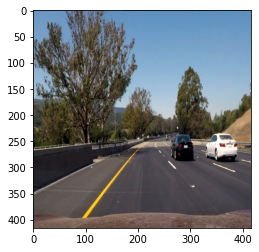

In [26]:
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print("Blob to show shape: {}".format(blob_to_show.shape))
blob_to_show = cv2.cvtColor(blob_to_show, cv2.COLOR_BGR2RGB)
plt.imshow(blob_to_show)

After we prepared and preprocessed the image to be ready feeding it into the network, we will load the network and its needed files

*   car_class.names
*   yolov4-car_train_best.weights
*   yolov4-car_train.cfg



In [8]:
classes_names_path = '/content/gdrive/MyDrive/YOLO/darknet/data/car_class.names'
weights_path = '/content/gdrive/MyDrive/YOLO/weight_from_training/yolov4-car_train_best.weights'
cfg_file_path = '/content/gdrive/MyDrive/YOLO/darknet/cfg/yolov4-car_train.cfg'

In [9]:
with open(classes_names_path) as f:
  labels = [line.strip() for line in f]
print("Labels:")
print(labels)

Labels:
['Car']


In [10]:
# Load the trained network by readNetFromDarknet function, it takes cfg and weights files as parameters
network = cv2.dnn.readNetFromDarknet(cfg_file_path, weights_path)

In [11]:
# Get all the layers names firstly, and then get only the output layers, because we 
# are going to use them later to get response from feedforward pass.
all_layers_names = network.getLayerNames()
print(all_layers_names)
output_layers_names = network.getUnconnectedOutLayersNames()
print(output_layers_names)

['conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38', 'conv_38', 'bn_38', 'mish

In [28]:
# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5
# Setting threshold for filtering weak bounding boxes with non-maximum suppression
threshold = 0.7

In [27]:
# Generating the color for bounding boxes
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8') 
# Since we have here only one class we will get only one color
print(colors)

[[132 243   6]]


In [29]:
# Implementing forward pass with the blob as input to the network
network.setInput(blob)
tik = time.time()
network_output = network.forward(output_layers_names)
tok = time.time()
print('Object detection took {:.5f} seconds'.format(tok - tik))

Object detection took 1.66016 seconds


In [30]:
# Getting bounding boxes
bounding_boxes = []
confidences = []
class_numbers = []

for result in network_output:
  for detected_object in result:
    scores = detected_object[5:]
    class_current = np.argmax(scores)
    confidence_current = scores[class_current]
    if confidence_current > probability_minimum:
      box_current = detected_object[:4] * np.array([width, height, width, height])
      x_center, y_center, box_width, box_height = box_current
      x_min = int(x_center - (box_width / 2))
      y_min = int(y_center - (box_height / 2))
      bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
      confidences.append(float(confidence_current))
      class_numbers.append(class_current)

results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

In [31]:
bounding_boxes

[[805, 407, 138, 91],
 [803, 407, 142, 92],
 [1002, 403, 204, 99],
 [1008, 404, 205, 95],
 [803, 414, 142, 87],
 [802, 414, 145, 87],
 [1001, 410, 207, 94],
 [1008, 411, 203, 92],
 [804, 407, 139, 95],
 [803, 407, 142, 95],
 [801, 405, 144, 98],
 [1000, 403, 212, 99],
 [999, 403, 214, 98],
 [997, 403, 217, 98],
 [988, 404, 237, 95]]

In [48]:
# Draw bounding boxes
counter = 0
final_bounding_boxes = []
if len(results) > 0:
  for i in results.flatten():
    print('Object {0}: {1}'.format(counter+1, labels[int(class_numbers[i])]))
    counter += 1
    x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
    box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
    color_box = colors[class_numbers[i]].tolist()
    cv2.rectangle(image, (x_min, y_min), (x_min+box_width, y_min+box_height), color_box, 2)
    text_box = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
    cv2.putText(image, text_box, (x_min, y_min - 5), cv2.FONT_HERSHEY_COMPLEX, 0.7, color_box, 2)
    final_bounding_boxes.append([x_min, y_min, box_width, box_height])

print()
print('Total detected objects: ', len(bounding_boxes))
print('Number of objects left after non-max-suppression:', counter)

Object 1: Car
Object 2: Car

Total detected objects:  15
Number of objects left after non-max-suppression: 2


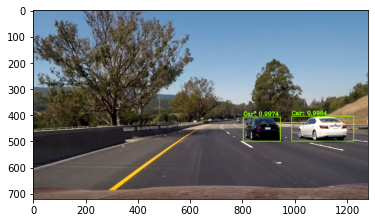

In [47]:
plt.imshow(image)
# cv2.imwrite('pred.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [49]:
final_bounding_boxes

[[988, 404, 237, 95], [803, 407, 142, 92]]